In [1]:
from nam.config import defaults
from nam.data import FoldedDataset, NAMDataset
from nam.models import NAM, get_num_units
from nam.trainer import LitNAM
from nam.utils import *
import pandas as pd
import pytorch_lightning as pl 
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

config = defaults()
config.num_epochs = 100

print(config)

#Config(activation='exu', batch_size=1024, cross_val=False, data_path='data/GALLUP.csv', decay_rate=0.995, device='cpu', dropout=0.5, early_stopping_patience=50, experiment_name='NAM', feature_dropout=0.5, fold_num=1, hidden_sizes=[64, 32], l2_regularization=0.5, logdir='output', lr=0.0003, num_basis_functions=1000, num_epochs=1, num_folds=5, num_models=1, num_splits=3, num_workers=16, optimizer='adam', output_regularization=0.5, regression=False, save_model_frequency=2, save_top_k=3, seed=2021, shuffle=True, units_multiplier=2, use_dnn=False, wandb=True)


config.regression = True



Config(activation='exu', batch_size=1024, cross_val=False, data_path='data/GALLUP.csv', decay_rate=0.995, device='cpu', dropout=0.5, early_stopping_patience=50, experiment_name='NAM', feature_dropout=0.5, fold_num=1, hidden_sizes=[64, 32], l2_regularization=0.5, logdir='output', lr=0.0003, num_basis_functions=1000, num_epochs=100, num_folds=5, num_models=1, num_splits=3, num_workers=16, optimizer='adam', output_regularization=0.5, regression=False, save_model_frequency=2, save_top_k=3, seed=2021, shuffle=True, units_multiplier=2, use_dnn=False, wandb=True)


In [2]:
import csv
import numpy as np
import pandas as pd
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math

np.random.seed(0)

bs=2 #This is the square root of the number of betas. Square root for plotting convenience
obs=10000 #Number of obs
const=5 #Constant a in y=a+beta*x+e
badd=1 #Multiplies the normally distributed random betas by a constant
eadd=1.7

#Creating the real underlying data
x=np.random.normal(size=[obs,bs**2])
errors=eadd*np.random.normal(size=[obs])
beta=badd*np.random.normal(size=[bs**2])
y=(const+np.matmul(np.sin(5*x),beta)+errors)


In [3]:
x1=pd.DataFrame(x,columns=["x1","x2","x3","x4"])
y1=pd.DataFrame(y,columns=["y"])
frames=[x1,y1]
result = pd.concat(frames,axis=1)

In [4]:
config = defaults()
config.num_epochs=100
config.regression = True

dataset = NAMDataset(config,
                      data_path=result,
                      features_columns=result.columns[:-1],
                      targets_column=result.columns[-1])


## Getting the training dataloaders
dataloaders = dataset.train_dataloaders()

In [5]:
model = NAM(
  config=config,
  name="NAM_SIM",
  num_inputs=len(dataset[0][0]),
  num_units=get_num_units(config, dataset.features),
)



C:\Users\morte\anaconda3\lib\site-packages\torch\nn\init.py:172: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


In [6]:
for fold, (trainloader, valloader) in enumerate(dataloaders):

    tb_logger = TensorBoardLogger(save_dir=config.logdir,
                                name=f'{model.name}',
                                version=f'fold_{fold + 1}')

    checkpoint_callback = ModelCheckpoint(filename=tb_logger.log_dir +
                                        "/{epoch:02d}-{val_loss:.4f}",
                                        monitor='val_loss',
                                        save_top_k=config.save_top_k,
                                        mode='min')

    litmodel = LitNAM(config, model)
    trainer = pl.Trainer(logger=tb_logger,
                       max_epochs=config.num_epochs,
                       checkpoint_callback=checkpoint_callback)
    trainer.fit(litmodel,
              train_dataloader=trainloader,
              val_dataloaders=valloader)


## Testing the trained model
trainer.test(test_dataloaders=dataset.test_dataloaders())


MisconfigurationException: Invalid type provided for checkpoint_callback: Expected bool but received <class 'pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint'>. Pass callback instances to the `callbacks` argument in the Trainer constructor instead.

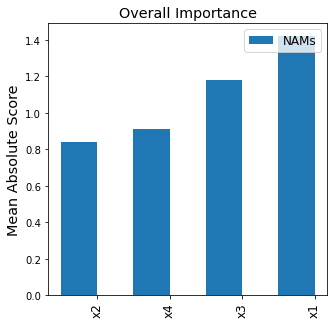

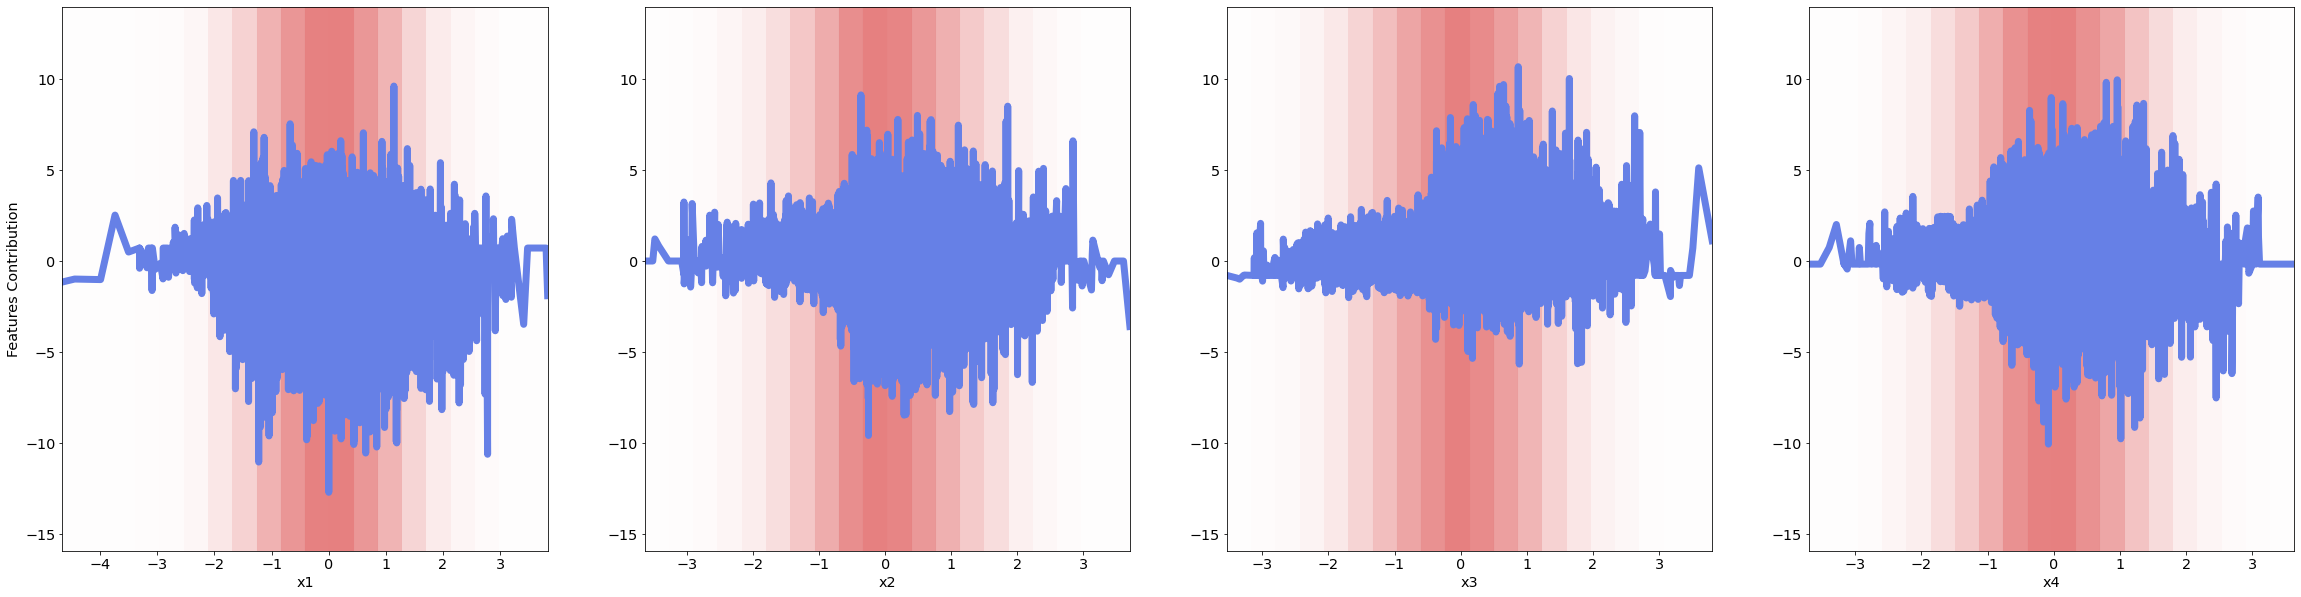

In [7]:
fig1 = plot_mean_feature_importance(litmodel.model, dataset)

fig2 = plot_nams(litmodel.model, dataset, num_cols= 4)
